In [1]:
## Please remember to update "COT.py" to the newest version

import numpy as np
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from COT import COT

In [2]:
## Download GSE28490

import GEOparse

gse = GEOparse.get_GEO(geo="GSE28490", destdir="./", silent=True)

In [3]:
## Select needed cell types

cellTypes = {"Neutrophils": [], "NK": [], "CD19+ B": [], "CD8+ T": [], "CD14+ monocytes": []}

sampleType = [] # cell type labels
for cell in cellTypes:
    for gsm in gse.phenotype_data.index.values:
        if cell in gse.phenotype_data["source_name_ch1"][gsm]:
            cellTypes[cell].append(gsm)
            sampleType.append(cell)
            
samples = [] # sample ID
for cell in cellTypes:
    samples = samples + cellTypes[cell]   
    
data = gse.pivot_samples('VALUE')[samples] # selected raw data

In [4]:
## Run COT

cot = COT(df_raw=data, logarithmic_data=True)
cot.generate_subtype_means(sampleType)
cot.generate_cos_values()

COT: package initiated.
COT: subtype means generated.
COT: cos values generated.


In [5]:
## Estimate p-value

cot.estimate_p_values()

COT: estimating p-values ...
COT: iteration 1: 12.8015 seconds
COT: iteration 2: 11.5989 seconds
COT: iteration 3: 12.8419 seconds
COT: iteration 4: 12.5351 seconds
COT: iteration 5: 10.7100 seconds
COT: iteration 6: 10.4977 seconds
COT: p-values estimated.


COT: marker generated.


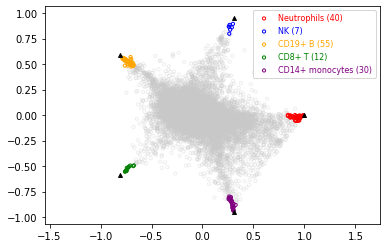

In [6]:
## Plot the markers on the simplex

cot.obtain_subtype_markers(top=144)
cot.plot_simplex()

COT: package initiated.
COT: subtype means generated.
COT: cos values generated.
COT: estimating p-values ...
COT: iteration 1: 12.6186 seconds
COT: iteration 2: 13.2929 seconds
COT: iteration 3: 13.6667 seconds
COT: iteration 4: 12.8777 seconds
COT: iteration 5: 11.1688 seconds
COT: iteration 6: 10.6962 seconds
COT: p-values estimated.
COT: marker generated.
COT: pipeline completed.


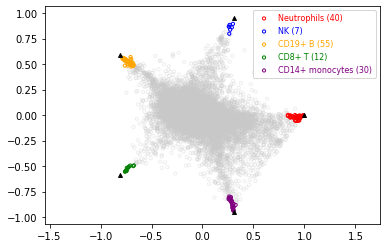

In [7]:
## or, use the COT pipeline

cot_pl = COT(df_raw=data, logarithmic_data=True)
cot_pl.cot_pipeline(subtype_label=sampleType, top=144)

In [8]:
## Compare OVO T-Test

import numpy as np
import pandas as pd

class OVO(COT):
    def generate_ovo_tstats(self):
        df_log = np.log2(self.df_raw)
        
        mean = df_log.apply(lambda x: np.array([np.mean(x[col]) for col in self.subtypes.values()]), axis=1)
        var = df_log.apply(lambda x: np.array([np.var(x[col], ddof=1) for col in self.subtypes.values()]), axis=1)
        n = df_log.apply(lambda x: np.array([len(col) for col in self.subtypes.values()]), axis=1)
        
        idx = mean.apply(lambda x: np.argmax(x))
        ovo = pd.DataFrame({'mean': mean, 'n': n, 'var': var, 'idx': idx}) \
                .apply(lambda x: (x['mean'][x['idx']] - x['mean']) / np.sqrt(x['var'][x['idx']] / x['n'][x['idx']] + x['var'] / x['n']), axis=1) \
                .apply(lambda x: np.sort(x)).apply(lambda x: x[1])
        
        subtype = idx.apply(lambda x: list(self.subtypes.keys())[x])
        self.df_ovo = pd.DataFrame({'ovo': ovo, 'subtype': subtype}, index=df_log.index)
        
        if not self.silent:
            print(f"OVO: ovo t-stats generated.")
    
    def obtain_subtype_markers(self, top=None):
        self.markers = {i: [] for i in self.subtypes.keys()}
        
        df_select = self.df_ovo.loc[self.df_ovo['ovo'].sort_values(ascending=False)[:top].index]
        for subtype in self.markers.keys():
            self.markers[subtype] = df_select[df_select['subtype'] == subtype].index
        
        if not self.silent:
            print(f"OVO: marker generated.")
    
    def ovo_pipeline(self, subtype_label, top=None):
        self.generate_subtype_means(subtype_label)
        self.generate_ovo_tstats()
        self.obtain_subtype_markers(top=top)
        self.plot_simplex()
        
        if not self.silent:
            print(f"OVO: pipeline completed.")


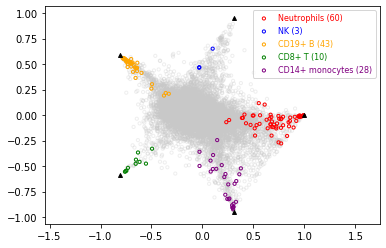

In [9]:
## Run OVO

ovo = OVO(df_raw=data, logarithmic_data=True, silent=True)
ovo.generate_subtype_means(sampleType)
ovo.generate_ovo_tstats()

ovo.obtain_subtype_markers(top=144)
ovo.plot_simplex()

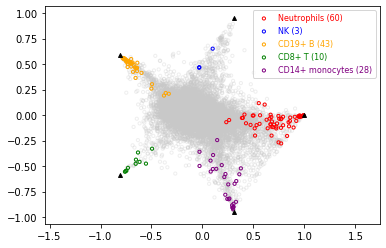

In [10]:
## or, use the OVO pipeline

ovo_pl = OVO(df_raw=data, logarithmic_data=True, silent=True)
ovo_pl.ovo_pipeline(subtype_label=sampleType, top=144)

In [11]:
## plot heatmap

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(cot, label, vmin=-1.00, vmax=+2.00):
    index = [marker for markers in cot.markers.values() for marker in markers]
    data = StandardScaler().fit_transform(cot.df_raw.loc[index].T)
    
    sns.heatmap(data, vmin=vmin, vmax=vmax, cbar=False, cmap=sns.diverging_palette(255, 0, n=100))
    plt.xticks([])
    plt.yticks([])
    plt.title(label)
    
    plt.show()


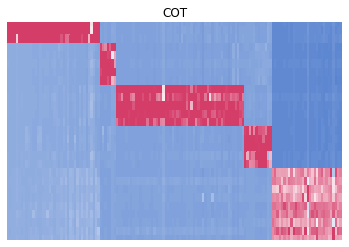

In [12]:
## COT heatmap

plot_heatmap(cot, 'COT')

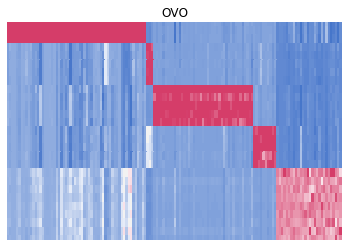

In [13]:
## OVO heatmap

plot_heatmap(ovo, 'OVO')